# Imports

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
#%pip install mtcnn
#from mtcnn.mtcnn import MTCNN
import matplotlib.patches as patches

from keras.utils import np_utils
import datetime
import pandas as pd

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pickle

from PIL import Image
from sklearn.metrics import accuracy_score

import keras
from keras.preprocessing import image
from tensorflow import keras
from sklearn import metrics
import numpy
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input, GlobalAvgPool2D
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50

import cv2
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image

import shutil
from shutil import unpack_archive
from subprocess import check_output
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
#from keras.optimizers import SGD
import tensorflow
from tensorflow.keras.utils import load_img, img_to_array 
import itertools

!pip install Keras-Applications
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install graphviz
!pip install -q pydot
path = "/content/lfw-deepfunneled/"
path_working = "/content/input/temp/working/"
!unzip /content/lfw-deepfunneled.zip

# Functions

In [2]:
# load subset with scikit loader
def load_data():
    path = "/content/lfw-deepfunneled/"
    lfw_allnames = pd.read_csv(path+"lfw_allnames.csv")
    matchpairsDevTest = pd.read_csv(path+"matchpairsDevTest.csv")
    matchpairsDevTrain = pd.read_csv(path+"matchpairsDevTrain.csv")
    mismatchpairsDevTest = pd.read_csv(path+"mismatchpairsDevTest.csv")
    mismatchpairsDevTrain = pd.read_csv(path+"mismatchpairsDevTrain.csv")
    pairs = pd.read_csv(path+"pairs.csv")
    # tidy pairs data: 
    pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
    matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
    mismatched_pairs = pairs[pairs["name2"].notnull()]
    people = pd.read_csv(path+"people.csv")
    # remove null values
    people = people[people.name.notnull()]
    peopleDevTest = pd.read_csv(path+"peopleDevTest.csv")
    peopleDevTrain = pd.read_csv(path+"peopleDevTrain.csv")

    # shape data
    image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
    image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
    image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
    image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
    image_paths = image_paths.drop("images",1)
    return image_paths

In [3]:
def create_subset(image_paths):
    count = image_paths['name'].value_counts()
    print("The following people have more than 70 pictures in the dataset: ")
    print(count[count>70])
    print("These people will be used in the subset to train the model.")
    # 7 people have more than 70 pictures in the dataset, so they will be used for training the model
    # to ensure more balanced classes only 70 of the pictures were used to train the model
    image_paths['name'].value_counts()[:7]

    multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(70),
                            image_paths[image_paths.name=="Colin_Powell"].sample(70),
                            image_paths[image_paths.name=="Tony_Blair"].sample(70),
                            image_paths[image_paths.name=="Donald_Rumsfeld"].sample(70),
                            image_paths[image_paths.name=="Gerhard_Schroeder"].sample(70),
                            image_paths[image_paths.name=="Ariel_Sharon"].sample(70),
                            image_paths[image_paths.name=="Hugo_Chavez"].sample(70)])
    #print(multi_data)
    return multi_data

In [4]:
# prints out the picture at the index
def print_picture(index):
    path = "/content/lfw-deepfunneled/"
    im = Image.open(path + str(image_paths.image_path[index]))
    plt.imshow(im)


In [5]:
from keras.preprocessing import image

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier):
    predictions = []
    for im in os.listdir(dir_name):
        test_image = tensorflow.keras.utils.load_img(dir_name + str(im), target_size = (250,250))
        test_image = keras.utils.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

In [42]:
# function for finding the precision and recall of predictions, for any number of predictive classes
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]
        if ((tp+fp) != 0):
            precision.append(tp/(tp + fp))
        else:
            precision.append(0)
        accuracy.append((tp + tn)/total_preds)
        recall.append(tp/(tp + fn))
    return(accuracy,precision,recall)

In [7]:
def directory_mover(data,dir_name):
    path = "/content/lfw-deepfunneled/"
    path_working = "/content/input/temp/working/"
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join(path_working,dir_name)):
            shutil.os.mkdir(os.path.join(path_working,dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        
        if not os.path.exists(os.path.join(path_working,dir_name,data_type)):
            shutil.os.mkdir(os.path.join(path_working,dir_name,data_type))
        path_from = os.path.join(path,image)
        path_to = os.path.join(path_working,dir_name,data_type)
        #print(path_to)
        shutil.copy(path_from, path_to)
        #print('Moved {} to {}'.format(image,path_to))
        co += 1
        
        #print('Moved {} images to {} folder.'.format(co,dir_name))


In [8]:
def shape_data(multi_train, multi_test, multi_val):
    path_working = "/content/input/temp/working/"
    # move images to separate directories
    directory_mover(multi_train,"train_multi/")
    directory_mover(multi_val,"val_multi/")
    directory_mover(multi_test,"test_multi/")

    train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
    test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
    multi_training_set = train_datagen.flow_from_directory(path_working + 'train_multi/',
                                                    target_size = (250, 250),
                                                    batch_size = 32,
                                                    class_mode = 'categorical')
    multi_val_set = test_datagen.flow_from_directory(path_working+'val_multi/',
                                                target_size = (250, 250),
                                                batch_size = 32,
                                                class_mode = 'categorical')
    multi_test_set = test_datagen.flow_from_directory(path_working+'test_multi/',
                                                target_size = (250, 250),
                                                batch_size = 32,
                                                class_mode = 'categorical')
    return multi_training_set, multi_test_set, multi_val_set

In [9]:
def get_multi_name_order():
    # classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
    multi_test_names = []
    # collect all file names
    for i in range(len(multi_test_set.filenames)):
        multi_test_names.append(multi_test_set.filenames[i])
    # extract unique names, in order
    for i in range(len(multi_test_names)):
        #print(multi_test_names[i])
        multi_test_names[i] = multi_test_names[i].split("/")[0]
    multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))
    print(multi_test_name_order)
    return multi_test_name_order

In [10]:
def plot_accuracy_loss(function_model):
    plt.plot(function_model.history['accuracy'])
    plt.plot(function_model.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(function_model.history['loss'])
    plt.plot(function_model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [11]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    classes = np.array(classes)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    tick_marks = np.arange(0, len(classes))
    plt.xticks(tick_marks.astype(int), classes[tick_marks], rotation=90)
    plt.yticks(tick_marks.astype(int), classes[tick_marks])
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.colorbar()
    plt.ylabel('True label', fontsize='x-large')
    plt.xlabel('Predicted label', fontsize='x-large')

# Load data


In [12]:
image_paths=load_data()
multi_data=create_subset(image_paths)

The following people have more than 70 pictures in the dataset: 
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Name: name, dtype: int64
These people will be used in the subset to train the model.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Test, if the data was correctly loaded by printing 1 picture:


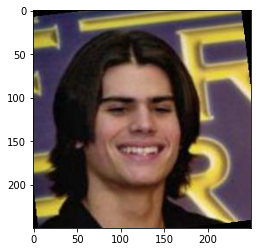

In [13]:
print("Test, if the data was correctly loaded by printing 1 picture:")
print_picture(1)

# Architecture 1
https://www.kaggle.com/code/jake126/face-detection-using-cnn-with-the-lfw-dataset/notebook#Detecting-Faces:-Using-a-CNN-model-to-Classify-Unseen-Faces-in-the-'Labelled-Faces-in-the-Wild'-Dataset
https://datagen.tech/guides/image-datasets/lfw-dataset/

In [ ]:
# split data in train, test and val
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# perform data augmentation and shape data subset correct
multi_training_set, multi_test_set, multi_val_set = shape_data(multi_train, multi_test, multi_val)

Found 745 images belonging to 7 classes.
Found 281 images belonging to 7 classes.
Found 329 images belonging to 7 classes.


In [ ]:
multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
multi_classifier.add(MaxPooling2D(pool_size = (2, 2)))
multi_classifier.add(Flatten())
multi_classifier.add(Dense(units = 128, activation = 'relu'))
multi_classifier.add(Dense(units = 7, activation = 'softmax'))
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#categorical_crossentropy is used for multi-class problems

In [ ]:
multi_classifier.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 flatten_6 (Flatten)         (None, 492032)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               62980224  
                                                                 
 dense_9 (Dense)             (None, 7)                 903       
                                                                 
Total params: 62,982,023
Trainable params: 62,982,023
Non-trainable params: 0
_________________________________________

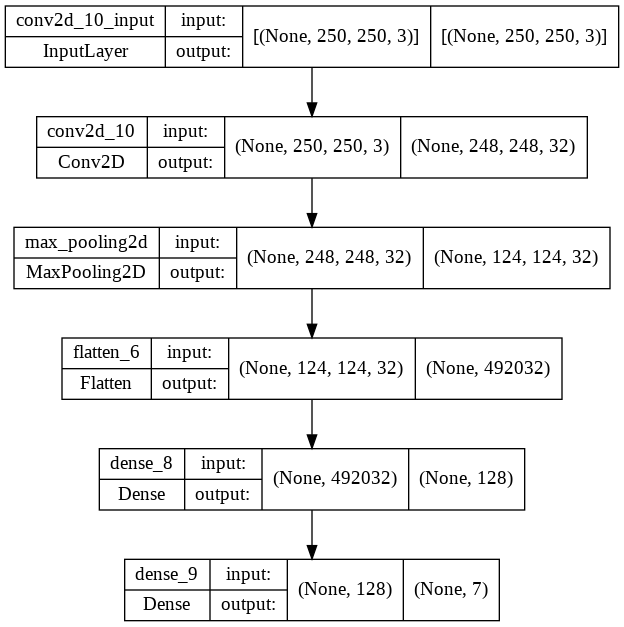

In [ ]:
plot_model(multi_classifier, to_file='cnn_model1.png', show_shapes=True, show_layer_names=True)

In [ ]:
training_steps=multi_training_set.n/multi_training_set.batch_size # set steps_per_epoch to number of training images
print(training_steps)
validation_steps=multi_val_set.n/multi_val_set.batch_size
print(validation_steps)
# multi_classifier.fit_generator -> supports data augmentation
multi_history = multi_classifier.fit_generator(multi_training_set,
                                               epochs = 40,
                                               steps_per_epoch=training_steps, # needed because otherwise keras data generator loops indefinitely
                                               validation_data = multi_val_set,
                                               validation_steps = validation_steps)

23.28125
8.78125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/40
23/23 [==============================] - 46s 2s/step - loss: 9.4909 - accuracy: 0.1906 - val_loss: 2.1391 - val_accuracy: 0.1779
Epoch 2/40
23/23 [==============================] - 47s 2s/step - loss: 1.8500 - accuracy: 0.2738 - val_loss: 1.8253 - val_accuracy: 0.2562
Epoch 3/40
23/23 [==============================] - 45s 2s/step - loss: 1.7530 - accuracy: 0.3007 - val_loss: 1.6610 - val_accuracy: 0.3523
Epoch 4/40
23/23 [==============================] - 46s 2s/step - loss: 1.6039 - accuracy: 0.4054 - val_loss: 1.5201 - val_accuracy: 0.3808
Epoch 5/40
23/23 [==============================] - 47s 2s/step - loss: 1.3877 - accuracy: 0.5128 - val_loss: 1.3932 - val_accuracy: 0.4626
Epoch 6/40
23/23 [==============================] - 47s 2s/step - loss: 1.2783 - accuracy: 0.5772 - val_loss: 1.0789 - val_accuracy: 0.6299
Epoch 7/40
23/23 [==============================] - 47s 2s/step - loss: 1.0266 - accuracy: 0.6550 - val_loss: 0.9341 - val_accuracy: 0.6584
Epoch 8/40
23/23 [==

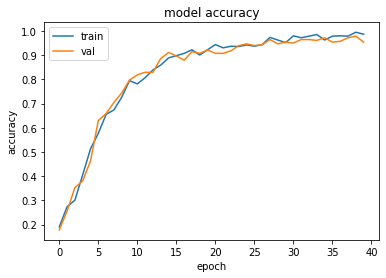

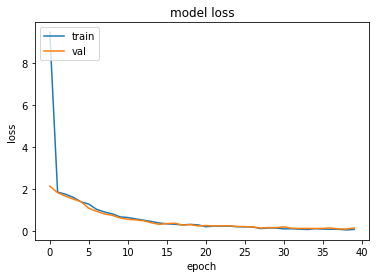

In [ ]:
plot_accuracy_loss(multi_history)

In [ ]:
multi_test_name_order=get_multi_name_order()

['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


In [ ]:
path_working = "/content/input/temp/working/"
multi_predictions_0 = predictions(path_working+"test_multi/" + multi_test_name_order[0] + "/", multi_classifier)
multi_predictions_1 = predictions(path_working+"test_multi/" + multi_test_name_order[1] + "/", multi_classifier)
multi_predictions_2 = predictions(path_working+"test_multi/" + multi_test_name_order[2] + "/", multi_classifier)
multi_predictions_3 = predictions(path_working+"test_multi/" + multi_test_name_order[3] + "/", multi_classifier)
multi_predictions_4 = predictions(path_working+"test_multi/" + multi_test_name_order[4] + "/", multi_classifier)
multi_predictions_5 = predictions(path_working+"test_multi/" + multi_test_name_order[5] + "/", multi_classifier)
multi_predictions_6 = predictions(path_working+"test_multi/" + multi_test_name_order[6] + "/", multi_classifier)

In [ ]:
multi_predictions_frame = pd.DataFrame(list(zip(multi_predictions_0 + multi_predictions_1 + multi_predictions_2 + multi_predictions_3 + multi_predictions_4 + multi_predictions_5 + multi_predictions_6,
                                                [0] * len(multi_predictions_0) + [1] * len(multi_predictions_1) + [2] * len(multi_predictions_2) + [3] * len(multi_predictions_3) + [4] * len(multi_predictions_4) + [5] * len(multi_predictions_5) + [6] * len(multi_predictions_6))),
                                       columns = ['Predictions','Actual'])

#print(multi_predictions_frame)

In [ ]:
multi_accuracy = prec_acc(multi_predictions_frame)
print('Precision:' + str(multi_accuracy[1]))
print('Recall:' + str(multi_accuracy[2]))
print(multi_test_name_order)

Precision:[0.9782608695652174, 1.0, 0.8695652173913043, 0.6461538461538462, 0.9545454545454546, 1.0, 0.7777777777777778]
Recall:[0.9, 0.675, 0.9090909090909091, 0.8936170212765957, 0.8076923076923077, 0.7631578947368421, 0.9655172413793104]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


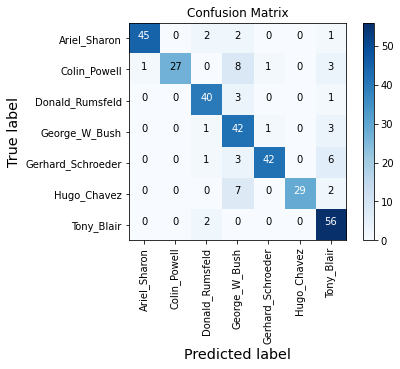

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(multi_predictions_frame['Actual'], multi_predictions_frame['Predictions'])
plot_confusion_matrix(confusion_matrix, multi_test_name_order)

# Architektur 2
inspired by the "Striving for Simplicity" approach by Springenberg et. al. (2015) 
https://github.com/emanuelfakh/Face-Recognition

In [30]:
image_paths=load_data()
multi_data=create_subset(image_paths)

The following people have more than 70 pictures in the dataset: 
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Name: name, dtype: int64
These people will be used in the subset to train the model.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [31]:
# split data in train, test and val
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# perform data augmentation and shape data subset correct
multi_training_set, multi_test_set, multi_val_set = shape_data(multi_train, multi_test, multi_val)

Found 818 images belonging to 7 classes.
Found 329 images belonging to 7 classes.
Found 391 images belonging to 7 classes.


In [32]:
from keras.layers import Input
from keras.layers import Conv2D, GlobalAvgPool2D
from keras.layers import Dropout, Activation

model2=Sequential()
model2.add(Conv2D(12, (3, 3), padding='same', activation='relu'))      
model2.add(Conv2D(12, (2, 2), strides=(2, 2), activation='relu'))      
model2.add(Conv2D(16, (3, 3), padding='same', activation='relu'))     
model2.add(Conv2D(16, (2, 2), strides=(2, 2), activation='relu'))     
model2.add(Conv2D(24, (3, 3), padding='same', activation='relu'))    
model2.add(Conv2D(24, (2, 2), strides=(2, 2), activation='relu'))      
model2.add(Conv2D(32, (3, 3), padding='same', activation='relu'))    
model2.add(Conv2D(32, (2, 2), strides=(2, 2), activation='relu'))     
model2.add(Conv2D(48, (3, 3), padding='same', activation='relu'))    
model2.add(Conv2D(48, (2, 2), strides=(2, 2), activation='relu'))      
model2.add(Dropout(0.5))                                            
model2.add(Conv2D(7, (1, 1)))                                      
model2.add(GlobalAvgPool2D())     
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])                              


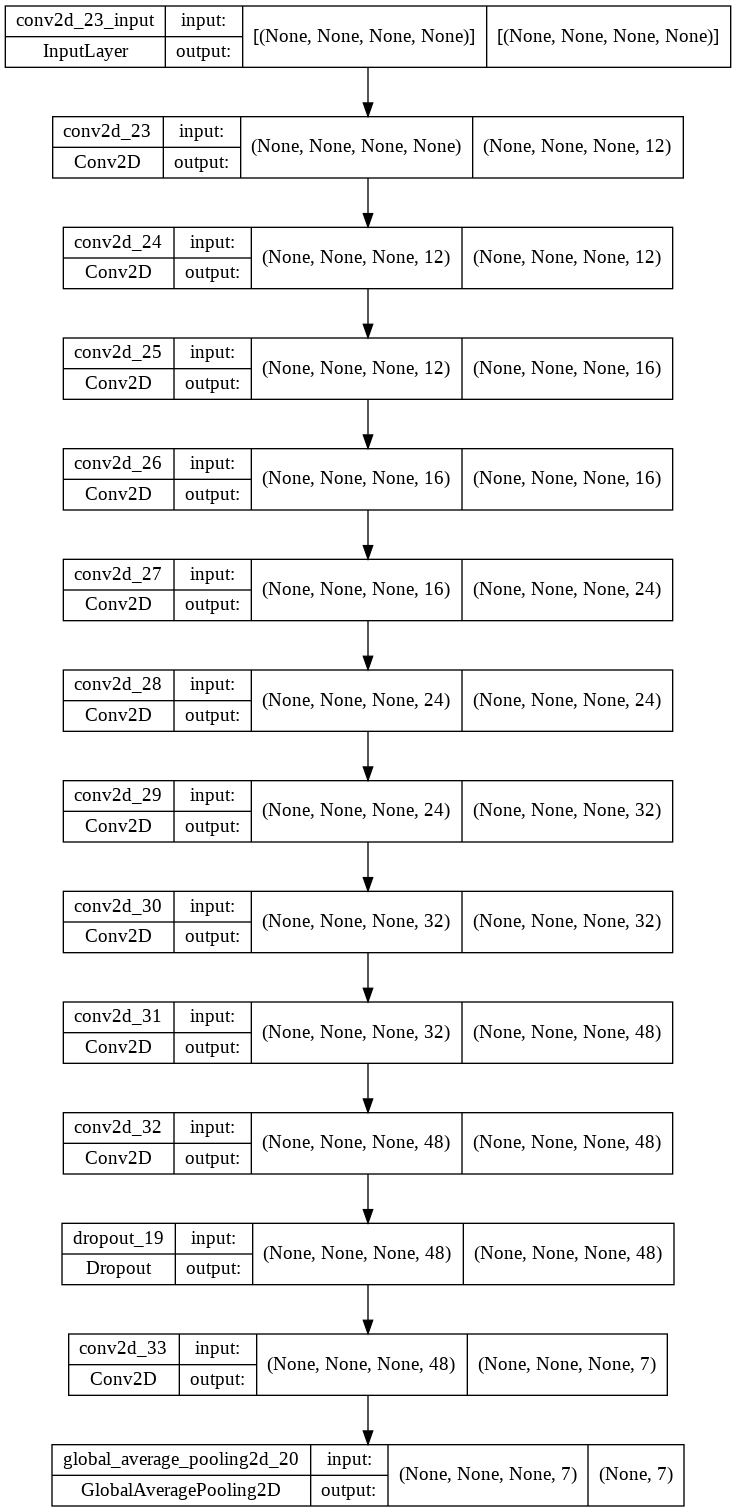

In [ ]:
plot_model(model2, to_file='cnn_model2.png', show_shapes=True, show_layer_names=True)

In [ ]:
model2.build()
model2.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, None, None, 12)    336       
                                                                 
 conv2d_24 (Conv2D)          (None, None, None, 12)    588       
                                                                 
 conv2d_25 (Conv2D)          (None, None, None, 16)    1744      
                                                                 
 conv2d_26 (Conv2D)          (None, None, None, 16)    1040      
                                                                 
 conv2d_27 (Conv2D)          (None, None, None, 24)    3480      
                                                                 
 conv2d_28 (Conv2D)          (None, None, None, 24)    2328      
                                                                 
 conv2d_29 (Conv2D)          (None, None, None, 32)  

In [33]:
training_steps=multi_training_set.n/multi_training_set.batch_size # set steps_per_epoch to number of training images
print(training_steps)
validation_steps=multi_val_set.n/multi_val_set.batch_size
print(validation_steps)
# multi_classifier.fit_generator -> supports data augmentation
model2_history =model2.fit_generator(multi_training_set,
                                               epochs = 20,
                                               steps_per_epoch=training_steps, # needed because otherwise keras data generator loops indefinitely
                                               validation_data = multi_val_set,
                                               validation_steps = validation_steps)

25.5625
10.28125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
25/25 [==============================] - 13s 434ms/step - loss: 8.2634 - accuracy: 0.1687 - val_loss: 8.7204 - val_accuracy: 0.1733
Epoch 2/20
25/25 [==============================] - 11s 424ms/step - loss: 8.0196 - accuracy: 0.1528 - val_loss: 7.0057 - val_accuracy: 0.1733
Epoch 3/20
25/25 [==============================] - 11s 417ms/step - loss: 8.0590 - accuracy: 0.1626 - val_loss: 7.2997 - val_accuracy: 0.1733
Epoch 4/20
25/25 [==============================] - 11s 419ms/step - loss: 7.7438 - accuracy: 0.1516 - val_loss: 7.2997 - val_accuracy: 0.1733
Epoch 5/20
25/25 [==============================] - 11s 416ms/step - loss: 8.4138 - accuracy: 0.1516 - val_loss: 8.7204 - val_accuracy: 0.1733
Epoch 6/20
25/25 [==============================] - 11s 418ms/step - loss: 8.0196 - accuracy: 0.1675 - val_loss: 8.7204 - val_accuracy: 0.1733
Epoch 7/20
25/25 [==============================] - 11s 423ms/step - loss: 7.7438 - accuracy: 0.1553 - val_loss: 8.7694 - val_accuracy: 0.1733

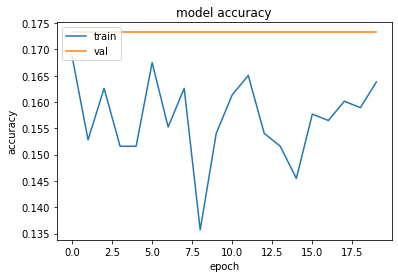

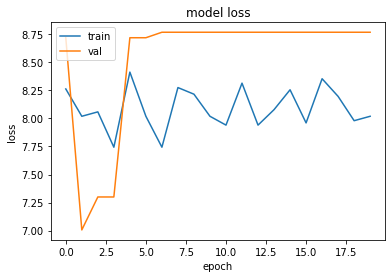

In [34]:
plot_accuracy_loss(model2_history)

In [35]:
multi_test_name_order=get_multi_name_order()

['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


In [36]:
path_working = "/content/input/temp/working/"
from keras.preprocessing import image
model2_predictions_0 = predictions(path_working+"test_multi/" + multi_test_name_order[0] + "/", model2)
model2_predictions_1 = predictions(path_working+"test_multi/" + multi_test_name_order[1] + "/", model2)
model2_predictions_2 = predictions(path_working+"test_multi/" + multi_test_name_order[2] + "/", model2)
model2_predictions_3 = predictions(path_working+"test_multi/" + multi_test_name_order[3] + "/", model2)
model2_predictions_4 = predictions(path_working+"test_multi/" + multi_test_name_order[4] + "/", model2)
model2_predictions_5 = predictions(path_working+"test_multi/" + multi_test_name_order[5] + "/", model2)
model2_predictions_6 = predictions(path_working+"test_multi/" + multi_test_name_order[6] + "/", model2)

In [37]:
model2_predictions_frame = pd.DataFrame(list(zip(model2_predictions_0 + model2_predictions_1 + model2_predictions_2 + model2_predictions_3 + model2_predictions_4 + model2_predictions_5 + model2_predictions_6,
                                                [0] * len(model2_predictions_0) + [1] * len(model2_predictions_1) + [2] * len(model2_predictions_2) + [3] * len(model2_predictions_3) + [4] * len(model2_predictions_4) + [5] * len(model2_predictions_5) + [6] * len(model2_predictions_6))),
                                       columns = ['Predictions','Actual'])

In [41]:
model2_accuracy = prec_acc(model2_predictions_frame)
print('Precision:' + str(model2_accuracy[1]))
print('Recall:' + str(model2_accuracy[2]))
print(multi_test_name_order)

Precision:[0, 0.4]
Recall:[0.0, 0.029850746268656716]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


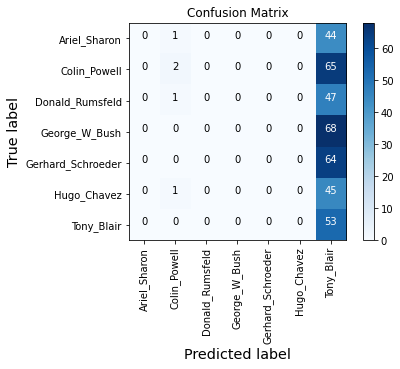

In [43]:
import sklearn.metrics as metrics
model2_confusion_matrix = metrics.confusion_matrix(model2_predictions_frame['Actual'], model2_predictions_frame['Predictions'])
plot_confusion_matrix(model2_confusion_matrix, classes=multi_test_name_order)

# Architecture 3
https://github.com/FRI-Deep-Learning/lfw-cnn

In [54]:
image_paths=load_data()
multi_data=create_subset(image_paths)

# split data in train, test and val
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# perform data augmentation and shape data subset correct
multi_training_set, multi_test_set, multi_val_set = shape_data(multi_train, multi_test, multi_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


The following people have more than 70 pictures in the dataset: 
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Name: name, dtype: int64
These people will be used in the subset to train the model.
Found 915 images belonging to 7 classes.
Found 427 images belonging to 7 classes.
Found 505 images belonging to 7 classes.


In [55]:
model3 = Sequential()

model3.add(Conv2D(32, (5, 5), input_shape = (250, 250, 3)))
model3.add(Activation("relu"))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation("relu"))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Conv2D(256, (1, 1)))
model3.add(Activation("relu"))
model3.add(Conv2D(512, (1, 1)))
model3.add(Activation("relu"))
model3.add(Flatten())
model3.add(Dense(7))
model3.add(Activation("softmax"))

model3.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

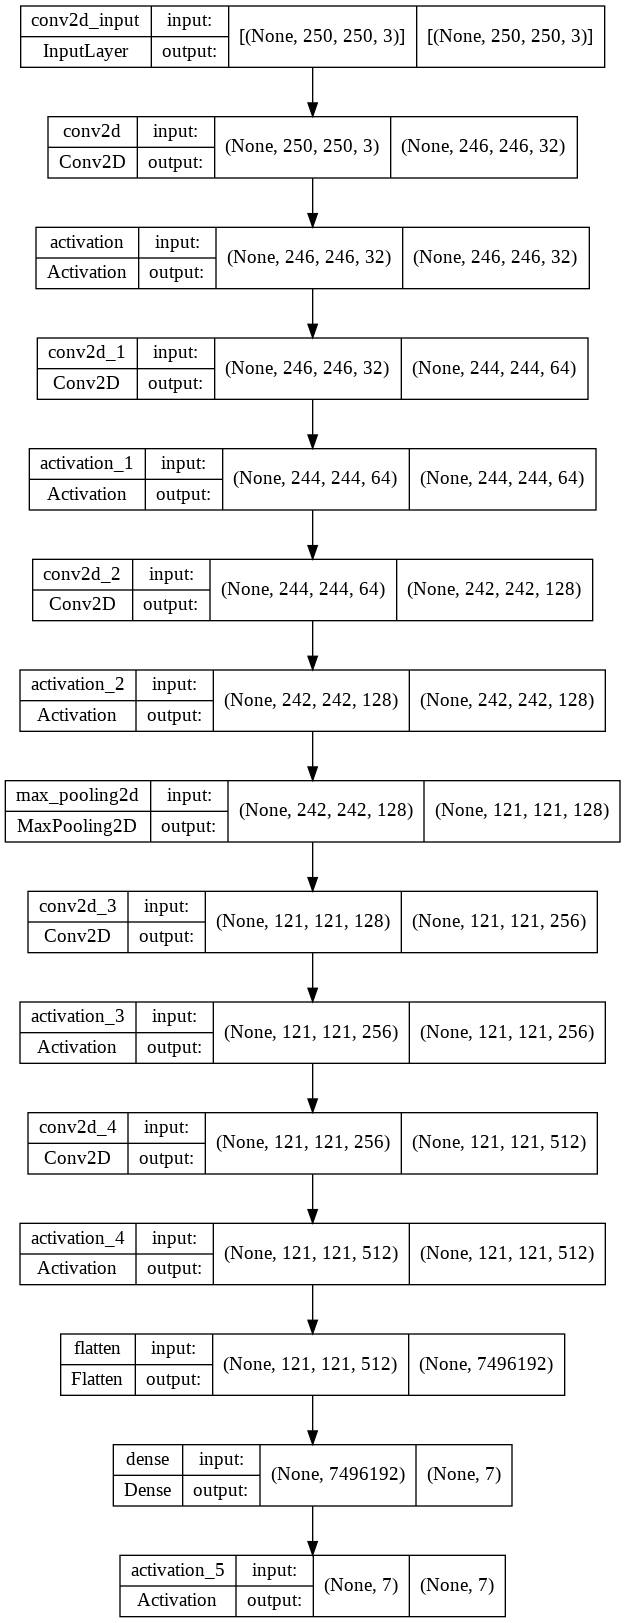

In [14]:
plot_model(model3, to_file='cnn_model3.png', show_shapes=True, show_layer_names=True)

In [15]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 246, 246, 32)      2432      
                                                                 
 activation (Activation)     (None, 246, 246, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 244, 244, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 244, 244, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 242, 242, 128)     73856     
                                                                 
 activation_2 (Activation)   (None, 242, 242, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 121, 121, 128)    0

In [56]:
training_steps=multi_training_set.n/multi_training_set.batch_size # set steps_per_epoch to number of training images
print(training_steps)
validation_steps=multi_val_set.n/multi_val_set.batch_size
print(validation_steps)
# multi_classifier.fit_generator -> supports data augmentation
model3_history = model3.fit_generator(multi_training_set,
                                               epochs = 47,
                                               steps_per_epoch=training_steps, # needed because otherwise keras data generator loops indefinitely
                                               validation_data = multi_val_set,
                                               validation_steps = validation_steps)

28.59375
13.34375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/47
28/28 [==============================] - 26s 884ms/step - loss: 1.8558 - accuracy: 0.2557 - val_loss: 1.8286 - val_accuracy: 0.2178
Epoch 2/47
28/28 [==============================] - 21s 740ms/step - loss: 1.7752 - accuracy: 0.3126 - val_loss: 1.7282 - val_accuracy: 0.3115
Epoch 3/47
28/28 [==============================] - 20s 706ms/step - loss: 1.6798 - accuracy: 0.3617 - val_loss: 1.6192 - val_accuracy: 0.4169
Epoch 4/47
28/28 [==============================] - 20s 695ms/step - loss: 1.6558 - accuracy: 0.3934 - val_loss: 1.5294 - val_accuracy: 0.4965
Epoch 5/47
28/28 [==============================] - 20s 705ms/step - loss: 1.5575 - accuracy: 0.4087 - val_loss: 1.6509 - val_accuracy: 0.4052
Epoch 6/47
28/28 [==============================] - 21s 709ms/step - loss: 1.6318 - accuracy: 0.3923 - val_loss: 1.5335 - val_accuracy: 0.4239
Epoch 7/47
28/28 [==============================] - 20s 702ms/step - loss: 1.4096 - accuracy: 0.4710 - val_loss: 1.5884 - val_accuracy: 0.3888

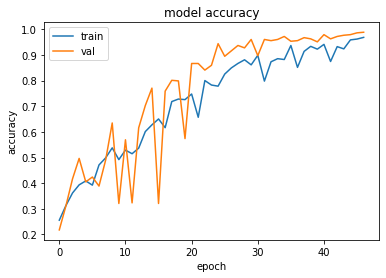

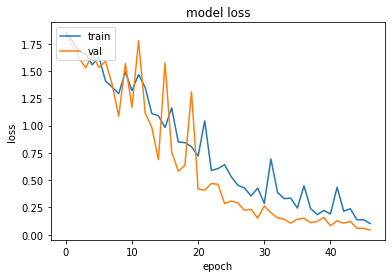

In [57]:
plot_accuracy_loss(model3_history)

In [58]:
multi_test_name_order=get_multi_name_order()

['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


In [59]:
model3_predictions_0 = predictions("input/temp/working/test_multi/" + multi_test_name_order[0] + "/", model3)
model3_predictions_1 = predictions("input/temp/working/test_multi/" + multi_test_name_order[1] + "/", model3)
model3_predictions_2 = predictions("input/temp/working/test_multi/" + multi_test_name_order[2] + "/", model3)
model3_predictions_3 = predictions("input/temp/working/test_multi/" + multi_test_name_order[3] + "/", model3)
model3_predictions_4 = predictions("input/temp/working/test_multi/" + multi_test_name_order[4] + "/", model3)
model3_predictions_5 = predictions("input/temp/working/test_multi/" + multi_test_name_order[5] + "/", model3)
model3_predictions_6 = predictions("input/temp/working/test_multi/" + multi_test_name_order[6] + "/", model3)

In [60]:
model3_predictions_frame = pd.DataFrame(list(zip(model3_predictions_0 + model3_predictions_1 + model3_predictions_2 + model3_predictions_3 + model3_predictions_4 + model3_predictions_5 + model3_predictions_6,
                                                [0] * len(model3_predictions_0) + [1] * len(model3_predictions_1) + [2] * len(model3_predictions_2) + [3] * len(model3_predictions_3) + [4] * len(model3_predictions_4) + [5] * len(model3_predictions_5) + [6] * len(model3_predictions_6))),
                                       columns = ['Predictions','Actual'])

In [61]:
model3_accuracy = prec_acc(model3_predictions_frame)
print('Precision:' + str(model3_accuracy[1]))
print('Recall:' + str(model3_accuracy[2]))
print(multi_test_name_order)

Precision:[0.9433962264150944, 0.7094017094017094, 0.9615384615384616, 0.6859504132231405, 0.6710526315789473, 1.0, 0.7903225806451613]
Recall:[0.8771929824561403, 0.9431818181818182, 0.8064516129032258, 0.8556701030927835, 0.6986301369863014, 0.43636363636363634, 0.6712328767123288]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


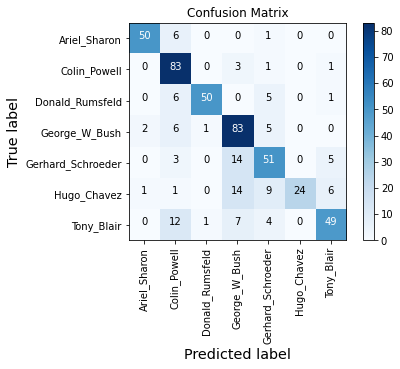

In [63]:
# confusion matrix
model3_confusion_matrix = metrics.confusion_matrix(model3_predictions_frame['Actual'], model3_predictions_frame['Predictions'])
plot_confusion_matrix(model3_confusion_matrix, multi_test_name_order)

# Architecture 4
https://github.com/StackAbuse/sa-image-recognition-keras/blob/main/SA-ImageRecognition.ipynb

In [45]:
image_paths=load_data()
multi_data=create_subset(image_paths)


# split data in train, test and val
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# perform data augmentation and shape data subset correct
multi_training_set, multi_test_set, multi_val_set = shape_data(multi_train, multi_test, multi_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


The following people have more than 70 pictures in the dataset: 
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Name: name, dtype: int64
These people will be used in the subset to train the model.
Found 870 images belonging to 7 classes.
Found 383 images belonging to 7 classes.
Found 447 images belonging to 7 classes.


In [46]:
model4 = Sequential()
model4.add(keras.layers.Conv2D(32, 3, input_shape=(250, 250, 3), activation='relu', padding='same'))
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.BatchNormalization())

model4.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model4.add(keras.layers.MaxPooling2D(2))
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.BatchNormalization())

model4.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model4.add(keras.layers.MaxPooling2D(2))
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.BatchNormalization())
    
model4.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.BatchNormalization())

model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.Dense(32, activation='relu'))
model4.add(keras.layers.Dropout(0.3))
model4.add(keras.layers.BatchNormalization())

model4.add(keras.layers.Dense(7, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

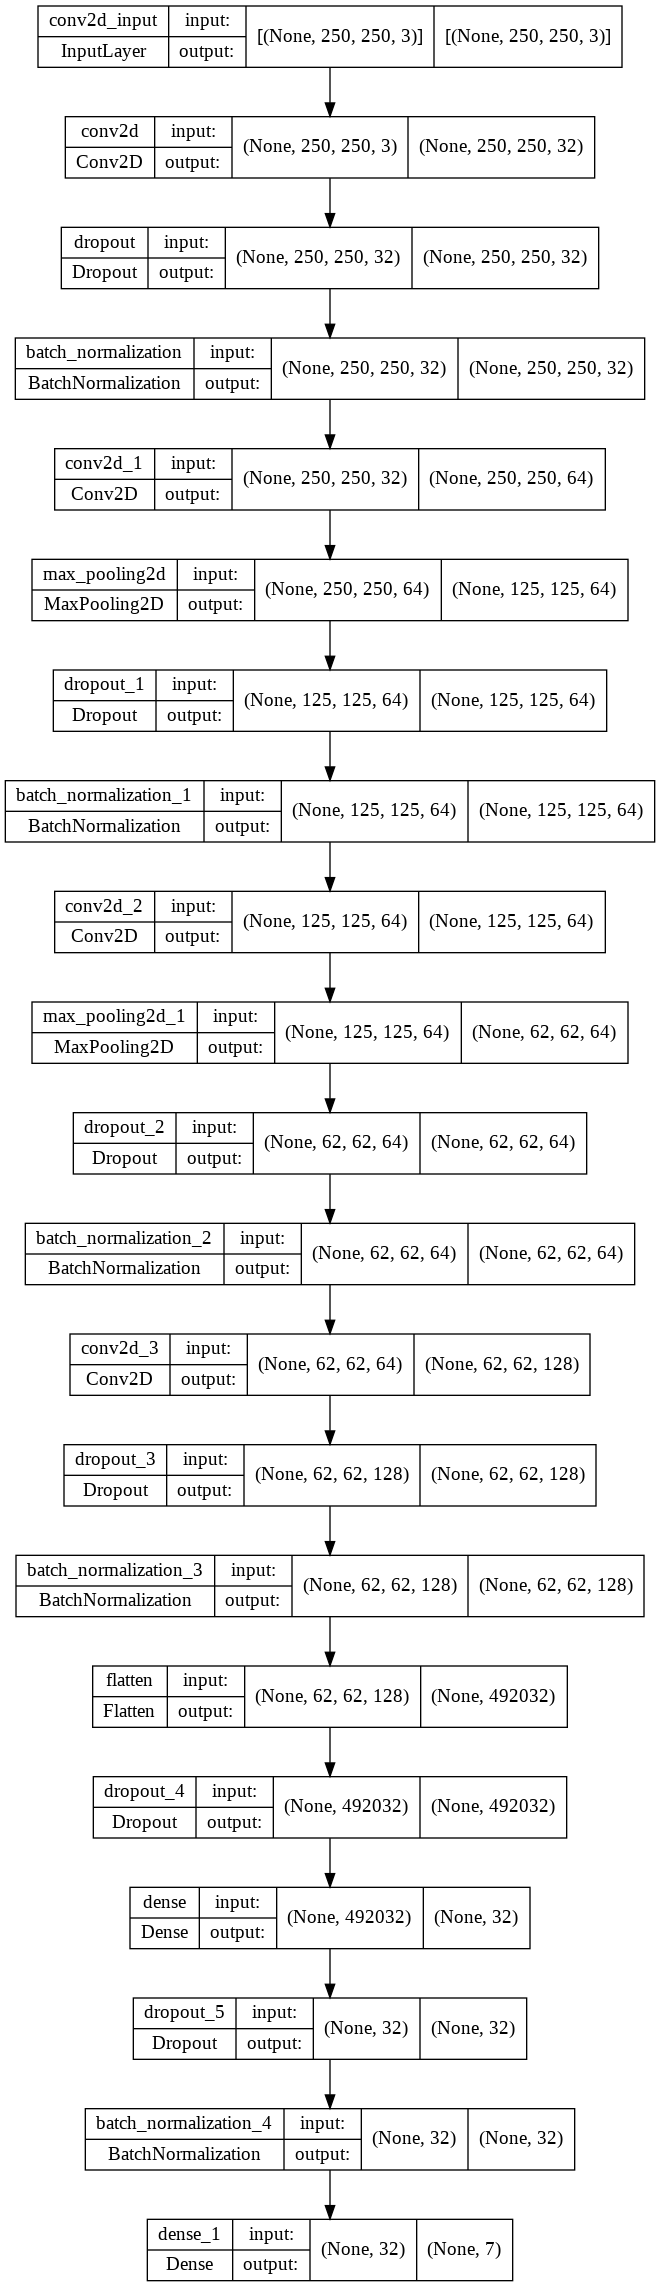

In [16]:
plot_model(model4, to_file='cnn_model4.png', show_shapes=True, show_layer_names=True)

In [15]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      896       
                                                                 
 dropout (Dropout)           (None, 250, 250, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 250, 250, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 64)     0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 125, 125, 64)      0

In [47]:
training_steps=multi_training_set.n/multi_training_set.batch_size # set steps_per_epoch to number of training images
print(training_steps)
validation_steps=multi_val_set.n/multi_val_set.batch_size
print(validation_steps)
# multi_classifier.fit_generator -> supports data augmentation
model4_history = model4.fit_generator(multi_training_set,
                                               epochs = 30,
                                               steps_per_epoch=training_steps, # needed because otherwise keras data generator loops indefinitely
                                               validation_data = multi_val_set,
                                               validation_steps = validation_steps)

27.1875
11.96875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
27/27 [==============================] - 20s 697ms/step - loss: 2.1257 - accuracy: 0.1632 - val_loss: 2.0507 - val_accuracy: 0.1645
Epoch 2/30
27/27 [==============================] - 13s 484ms/step - loss: 1.8163 - accuracy: 0.3034 - val_loss: 2.2282 - val_accuracy: 0.1697
Epoch 3/30
27/27 [==============================] - 13s 486ms/step - loss: 1.6030 - accuracy: 0.3989 - val_loss: 2.1109 - val_accuracy: 0.2637
Epoch 4/30
27/27 [==============================] - 13s 507ms/step - loss: 1.3820 - accuracy: 0.5230 - val_loss: 2.8861 - val_accuracy: 0.1279
Epoch 5/30
27/27 [==============================] - 13s 482ms/step - loss: 1.2997 - accuracy: 0.5437 - val_loss: 2.5111 - val_accuracy: 0.1305
Epoch 6/30
27/27 [==============================] - 13s 498ms/step - loss: 1.1862 - accuracy: 0.5966 - val_loss: 2.7509 - val_accuracy: 0.1384
Epoch 7/30
27/27 [==============================] - 13s 487ms/step - loss: 1.0036 - accuracy: 0.6621 - val_loss: 2.2555 - val_accuracy: 0.2428

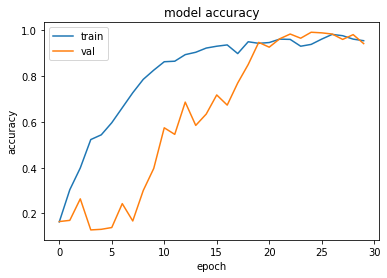

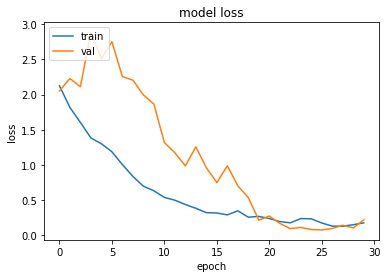

In [48]:
plot_accuracy_loss(model4_history)

In [49]:
multi_test_name_order=get_multi_name_order()

['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


In [50]:
path_working = "/content/input/temp/working/"
model4_predictions_0 = predictions(path_working+"test_multi/" + multi_test_name_order[0] + "/", model4)
model4_predictions_1 = predictions(path_working+"test_multi/" + multi_test_name_order[1] + "/", model4)
model4_predictions_2 = predictions(path_working+"test_multi/" + multi_test_name_order[2] + "/", model4)
model4_predictions_3 = predictions(path_working+"test_multi/" + multi_test_name_order[3] + "/", model4)
model4_predictions_4 = predictions(path_working+"test_multi/" + multi_test_name_order[4] + "/", model4)
model4_predictions_5 = predictions(path_working+"test_multi/" + multi_test_name_order[5] + "/", model4)
model4_predictions_6 = predictions(path_working+"test_multi/" + multi_test_name_order[6] + "/", model4)

In [51]:
model4_predictions_frame = pd.DataFrame(list(zip(model4_predictions_0 + model4_predictions_1 + model4_predictions_2 + model4_predictions_3 + model4_predictions_4 + model4_predictions_5 + model4_predictions_6,
                                                [0] * len(model4_predictions_0) + [1] * len(model4_predictions_1) + [2] * len(model4_predictions_2) + [3] * len(model4_predictions_3) + [4] * len(model4_predictions_4) + [5] * len(model4_predictions_5) + [6] * len(model4_predictions_6))),
                                       columns = ['Predictions','Actual'])

In [52]:
model4_accuracy = prec_acc(model4_predictions_frame)
print('Precision:' + str(model4_accuracy[1]))
print('Recall:' + str(model4_accuracy[2]))
print(multi_test_name_order)

Precision:[1.0, 1.0, 1.0, 0.8604651162790697, 0.8064516129032258, 0.3111111111111111, 0.3765432098765432]
Recall:[0.4117647058823529, 0.5714285714285714, 0.20754716981132076, 0.4457831325301205, 0.36231884057971014, 0.84, 0.953125]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


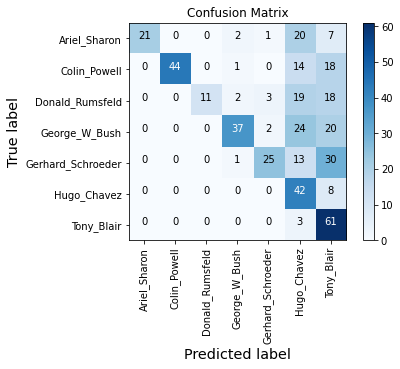

In [53]:
# confusion matrix
model4_confusion_matrix = metrics.confusion_matrix(model4_predictions_frame['Actual'], model4_predictions_frame['Predictions'])
plot_confusion_matrix(model4_confusion_matrix, multi_test_name_order)

# Transfer Learning with VGG16

In [43]:
image_paths=load_data()
multi_data=create_subset(image_paths)

# split data in train, test and val
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# perform data augmentation and shape data subset correct
multi_training_set, multi_test_set, multi_val_set = shape_data(multi_train, multi_test, multi_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


The following people have more than 70 pictures in the dataset: 
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Name: name, dtype: int64
These people will be used in the subset to train the model.
Found 755 images belonging to 7 classes.
Found 273 images belonging to 7 classes.
Found 338 images belonging to 7 classes.


In [44]:
model_vgg16 = Sequential()
base_model = VGG16(include_top=False, weights='imagenet', pooling='avg', input_shape=(250, 250, 3))
base_model.trainable = False
model_vgg16.add(base_model)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(units = 128, activation = 'relu'))
model_vgg16.add(Dense(units = 7, activation = 'softmax'))
model_vgg16.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [36]:
model_vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 7)                 903       
                                                                 
Total params: 14,781,255
Trainable params: 66,567
Non-trainable params: 14,714,688
_________________________________________________________________


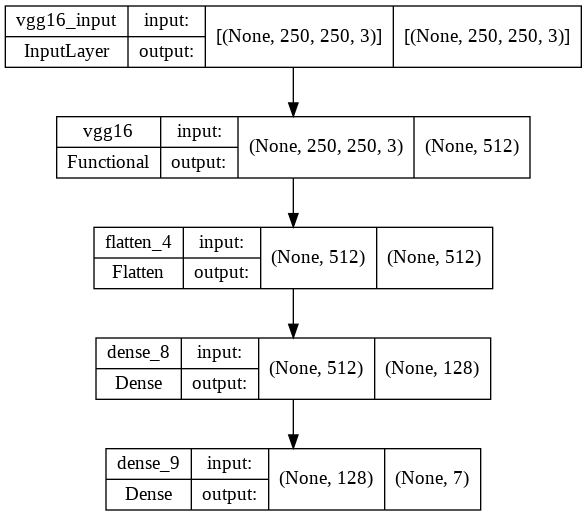

In [46]:
plot_model(model_vgg16, to_file='transfer_model_VGG16.png', show_shapes=True, show_layer_names=True)

In [45]:
training_steps=multi_training_set.n/multi_training_set.batch_size # set steps_per_epoch to number of training images
#print(training_steps)
validation_steps=multi_val_set.n/multi_val_set.batch_size
#print(validation_steps)
# multi_classifier.fit_generator -> supports data augmentation
transfer_vgg16_history = model_vgg16.fit_generator(multi_training_set,
                                               epochs = 30,
                                               steps_per_epoch=training_steps, # needed because otherwise keras data generator loops indefinitely
                                               validation_data = multi_val_set,
                                               validation_steps = validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
23/23 [==============================] - 17s 708ms/step - loss: 1.9477 - accuracy: 0.1868 - val_loss: 1.9275 - val_accuracy: 0.1355
Epoch 2/30
23/23 [==============================] - 12s 524ms/step - loss: 1.7659 - accuracy: 0.3113 - val_loss: 1.7738 - val_accuracy: 0.2454
Epoch 3/30
23/23 [==============================] - 12s 522ms/step - loss: 1.6698 - accuracy: 0.3921 - val_loss: 1.6909 - val_accuracy: 0.3590
Epoch 4/30
23/23 [==============================] - 12s 519ms/step - loss: 1.5723 - accuracy: 0.4424 - val_loss: 1.6415 - val_accuracy: 0.3077
Epoch 5/30
23/23 [==============================] - 12s 516ms/step - loss: 1.4835 - accuracy: 0.4901 - val_loss: 1.5091 - val_accuracy: 0.4542
Epoch 6/30
23/23 [==============================] - 12s 517ms/step - loss: 1.3799 - accuracy: 0.5616 - val_loss: 1.3786 - val_accuracy: 0.6374
Epoch 7/30
23/23 [==============================] - 12s 518ms/step - loss: 1.2850 - accuracy: 0.6040 - val_loss: 1.2781 - val_accuracy: 0.6557

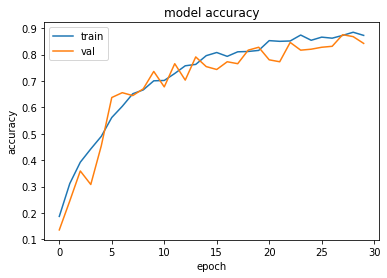

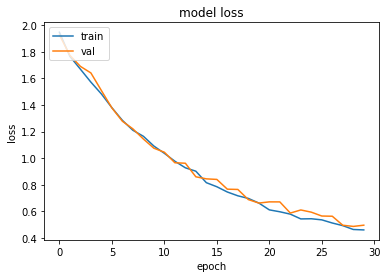

In [46]:
plot_accuracy_loss(transfer_vgg16_history)

In [47]:
transfer4_predictions_0 = predictions(path_working+"test_multi/" + multi_test_name_order[0] + "/", model_vgg16)
transfer4_predictions_1 = predictions(path_working+"test_multi/" + multi_test_name_order[1] + "/", model_vgg16)
transfer4_predictions_2 = predictions(path_working+"test_multi/" + multi_test_name_order[2] + "/", model_vgg16)
transfer4_predictions_3 = predictions(path_working+"test_multi/" + multi_test_name_order[3] + "/", model_vgg16)
transfer4_predictions_4 = predictions(path_working+"test_multi/" + multi_test_name_order[4] + "/", model_vgg16)
transfer4_predictions_5 = predictions(path_working+"test_multi/" + multi_test_name_order[5] + "/", model_vgg16)
transfer4_predictions_6 = predictions(path_working+"test_multi/" + multi_test_name_order[6] + "/", model_vgg16)

In [48]:
transfer4_predictions_frame = pd.DataFrame(list(zip(transfer4_predictions_0 + transfer4_predictions_1 + transfer4_predictions_2 + transfer4_predictions_3 + transfer4_predictions_4 + transfer4_predictions_5 + transfer4_predictions_6,
                                                [0] * len(transfer4_predictions_0) + [1] * len(transfer4_predictions_1) + [2] * len(transfer4_predictions_2) + [3] * len(transfer4_predictions_3) + [4] * len(transfer4_predictions_4) + [5] * len(transfer4_predictions_5) + [6] * len(transfer4_predictions_6))),
                                       columns = ['Predictions','Actual'])

In [49]:
transfer4_accuracy = prec_acc(transfer4_predictions_frame)
print('Precision:' + str(transfer4_accuracy[1]))
print('Recall:' + str(transfer4_accuracy[2]))
print(multi_test_name_order)

Precision:[0.7142857142857143, 0.7857142857142857, 1.0, 0.25, 1.0, 0.7619047619047619, 0.21755725190839695]
Recall:[0.125, 0.39285714285714285, 0.34146341463414637, 0.01694915254237288, 0.044444444444444446, 0.4, 1.0]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


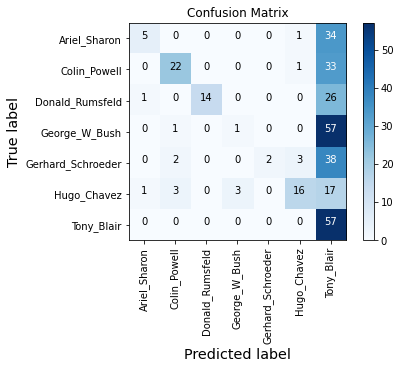

In [50]:
transfer_vgg16_confusion_matrix = metrics.confusion_matrix(transfer4_predictions_frame['Actual'], transfer4_predictions_frame['Predictions'])
plot_confusion_matrix(transfer_vgg16_confusion_matrix, multi_test_name_order)